In [1]:
# !pip install ultralytics -q

In [2]:

# Object Detecion 
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm.notebook import tqdm

# Display image and videos
import IPython
from IPython.display import Video, display
%matplotlib inline

# A Vehicle Detection and Counting project based on the Yolo V8 Model.
----------------------
 **The objectives of the project are:**
 - Detect vehicles in an highway - (cars, trucks, bus and motorcycles)
 - Count the number of vehicles that pass thought a transition line indicating the direction they are going to. ( in\ou)
 - Count the total number of each class have passed in the highway
 
 --------------------

In [8]:
!ls

b.dav	   best.pt		ultra.py
best.onnx  frame_prediction.py	yolo-v8-vehicles-detecting-counting.ipynb


In [9]:
# Video  path for experiment
path = 'b.dav'

In [11]:
# Displaying the target video 
frac = 0.65 
display(Video(data=path), height=int(720*frac), width=int(1280*frac))

In [12]:
#loading a YOLO model 
model = YOLO('best.pt')

#geting names from classes
dict_classes = model.model.names
dict_classes

{0: 'car', 1: 'bus', 2: 'van', 3: 'truck', 4: 'bike', 5: 'rickshaw'}

In [13]:
# Auxiliary functions
def risize_frame(frame, scale_percent):
    """Function to resize an image in a percent scale"""
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    return resized


# Detecting Vehicles 

In [15]:

### Configurations
#Verbose during prediction
verbose = False
# Scaling percentage of original frame
scale_percent = 50


#-------------------------------------------------------
# Reading video with cv2
video = cv2.VideoCapture(path)

# Objects to detect Yolo
class_IDS = [0,1,2,3,4,5] 
# Auxiliary variables
centers_old = {}
centers_new = {}
obj_id = 0 
veiculos_contador_in = dict.fromkeys(class_IDS, 0)
veiculos_contador_out = dict.fromkeys(class_IDS, 0)
end = []
frames_list = []
cy_linha = int(1500 * scale_percent/100 )
cx_sentido = int(2000 * scale_percent/100) 
offset = int(8 * scale_percent/100 )
contador_in = 0
contador_out = 0
print(f'[INFO] - Verbose during Prediction: {verbose}')


# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance 
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))
    

#-------------------------------------------------------
### Video output ####
video_name = 'result.mp4'
output_path = "rep_" + video_name
tmp_output_path = "tmp_" + output_path
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(tmp_output_path, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))


#-------------------------------------------------------
# Executing Recognition 
for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)))):
    
    # reading frame from video
    _, frame = video.read()
    
    #Applying resizing of read frame
    frame  = risize_frame(frame, scale_percent)
    
    if verbose:
        print('Dimension Scaled(frame): ', (frame.shape[1], frame.shape[0]))

    # Getting predictions
    y_hat = model.predict(frame, conf = 0.7, classes = class_IDS, device = 'cpu', verbose = False)
    
    # Getting the bounding boxes, confidence and classes of the recognize objects in the current frame.
    boxes   = y_hat[0].boxes.xyxy.cpu().numpy()
    conf    = y_hat[0].boxes.conf.cpu().numpy()
    classes = y_hat[0].boxes.cls.cpu().numpy() 
    
    # Storing the above information in a dataframe
    positions_frame = pd.DataFrame(y_hat[0].cpu().numpy().boxes.boxes, columns = ['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class'])
    
    #Translating the numeric class labels to text
    labels = [dict_classes[i] for i in classes]
    
    # Drawing transition line for in\out vehicles counting 
    cv2.line(frame, (0, cy_linha), (int(4500 * scale_percent/100 ), cy_linha), (255,255,0),8)
    
    # For each vehicles, draw the bounding-box and counting each one the pass thought the transition line (in\out)
    for ix, row in enumerate(positions_frame.iterrows()):
        # Getting the coordinates of each vehicle (row)
        xmin, ymin, xmax, ymax, confidence, category,  = row[1].astype('int')
        
        # Calculating the center of the bounding-box
        center_x, center_y = int(((xmax+xmin))/2), int((ymax+ ymin)/2)
        
        # drawing center and bounding-box of vehicle in the given frame 
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 5) # box
        cv2.circle(frame, (center_x,center_y), 5,(255,0,0),-1) # center of box
        
        #Drawing above the bounding-box the name of class recognized.
        cv2.putText(img=frame, text=labels[ix]+' - '+str(np.round(conf[ix],2)),
                    org= (xmin,ymin-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0),thickness=2)
        
        # Checking if the center of recognized vehicle is in the area given by the transition line + offset and transition line - offset 
        if (center_y < (cy_linha + offset)) and (center_y > (cy_linha - offset)):
            if  (center_x >= 0) and (center_x <=cx_sentido):
                contador_in +=1
                veiculos_contador_in[category] += 1
            else:
                contador_out += 1
                veiculos_contador_out[category] += 1
    
    #updating the counting type of vehicle 
    contador_in_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_in.items()]
    contador_out_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_out.items()]
    
    #drawing the number of vehicles in\out
    cv2.putText(img=frame, text='N. vehicles In', 
                org= (30,30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                fontScale=1, color=(255, 255, 0),thickness=1)
    
    cv2.putText(img=frame, text='N. vehicles Out', 
                org= (int(2800 * scale_percent/100 ),30), 
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=1)
    
    #drawing the counting of type of vehicles in the corners of frame 
    xt = 40
    for txt in range(len(contador_in_plt)):
        xt +=30
        cv2.putText(img=frame, text=contador_in_plt[txt], 
                    org= (30,xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                    fontScale=1, color=(255, 255, 0),thickness=1)
        
        cv2.putText(img=frame, text=contador_out_plt[txt],
                    org= (int(2800 * scale_percent/100 ),xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=1, color=(255, 255, 0),thickness=1)
    
    #drawing the number of vehicles in\out
    cv2.putText(img=frame, text=f'In:{contador_in}', 
                org= (int(1820 * scale_percent/100 ),cy_linha+60),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)
    
    cv2.putText(img=frame, text=f'Out:{contador_out}', 
                org= (int(1800 * scale_percent/100 ),cy_linha-40),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)

    if verbose:
        print(contador_in, contador_out)
    #Saving frames in a list 
    frames_list.append(frame)
    #saving transformed frames in a output video formaat
    output_video.write(frame)
    
#Releasing the video    
output_video.release()


####  pos processing
# Fixing video output codec to run in the notebook\browser
if os.path.exists(output_path):
    os.remove(output_path)
    
subprocess.run(
    ["ffmpeg",  "-i", tmp_output_path,"-crf","18","-preset","veryfast","-hide_banner","-loglevel","error","-vcodec","libx264",output_path])
os.remove(tmp_output_path)


[INFO] - Verbose during Prediction: False
[INFO] - Original Dim:  (704, 576)
[INFO] - Scaling change may cause errors in pixels lines 
[INFO] - Dim Scaled:  (352, 288)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


  0%|          | 0/1425 [00:00<?, ?it/s]

Ultralytics YOLOv8.0.81 🚀 Python-3.8.0 torch-1.13.1+cu117 CPU
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
Model summary (fused): 268 layers, 43611234 parameters, 0 gradients
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
W

KeyboardInterrupt: 

# Sampling Transformed Frames Results

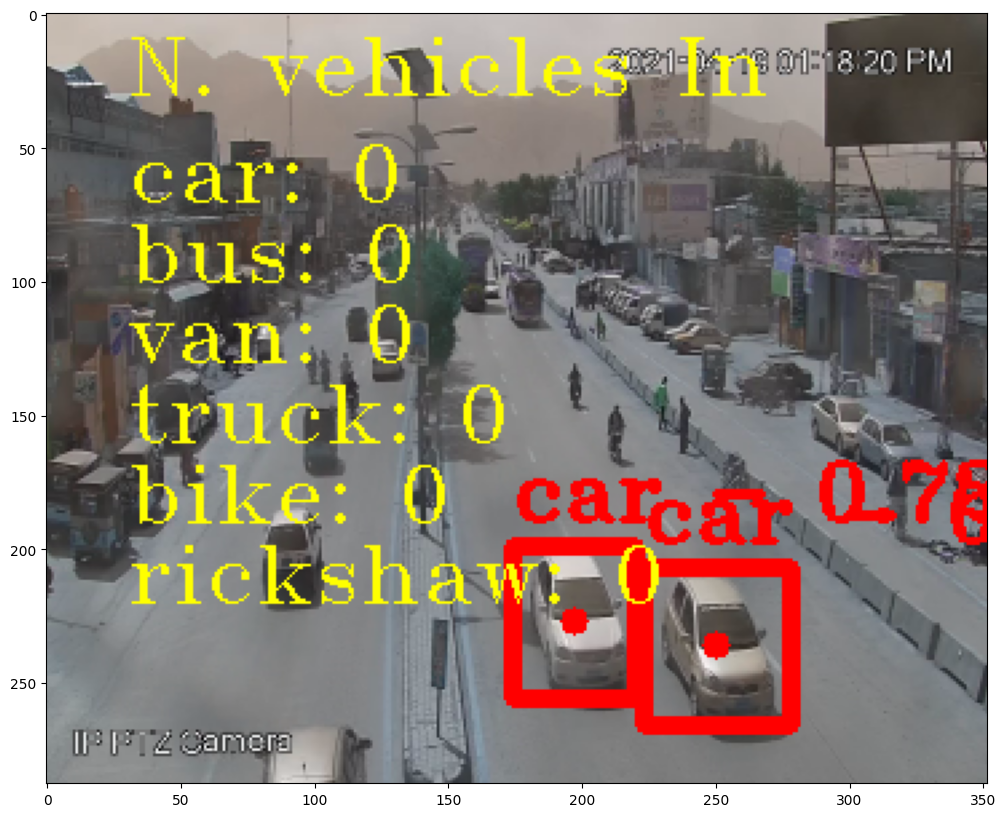

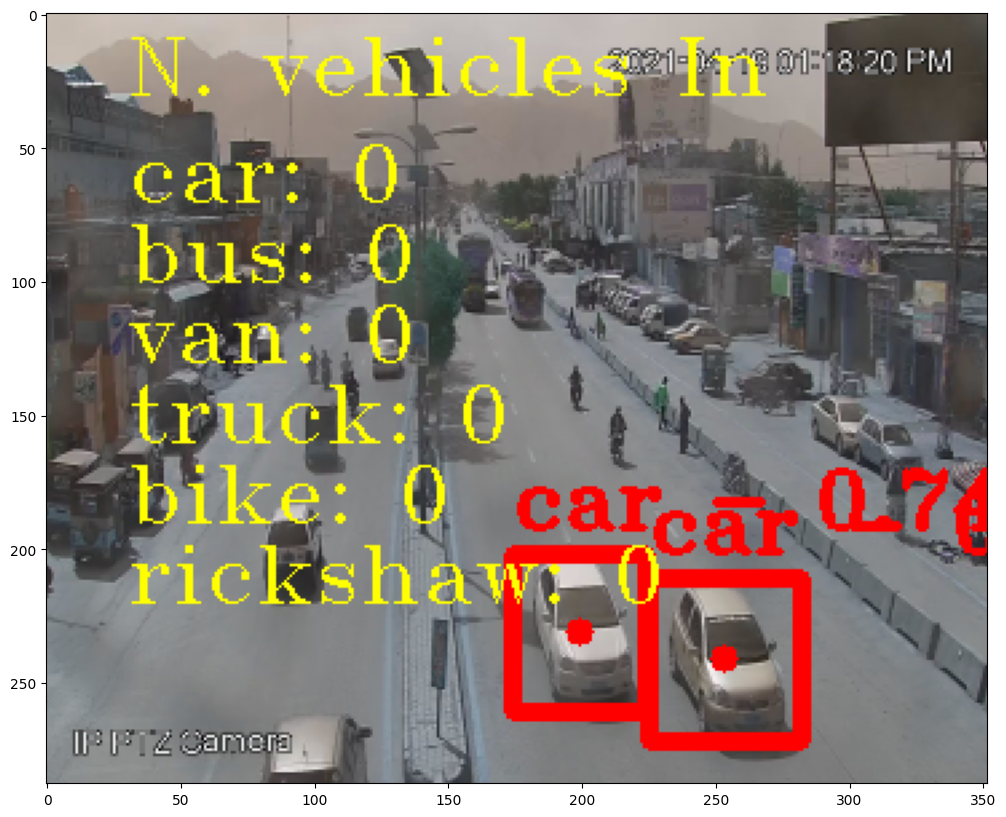

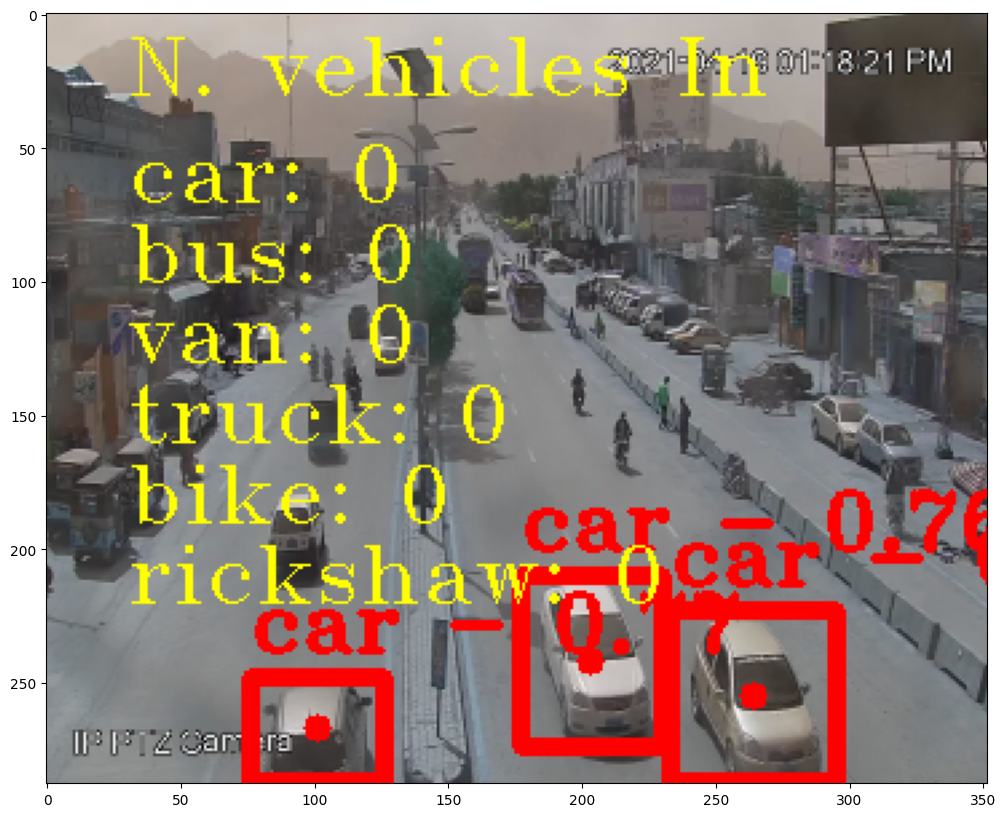

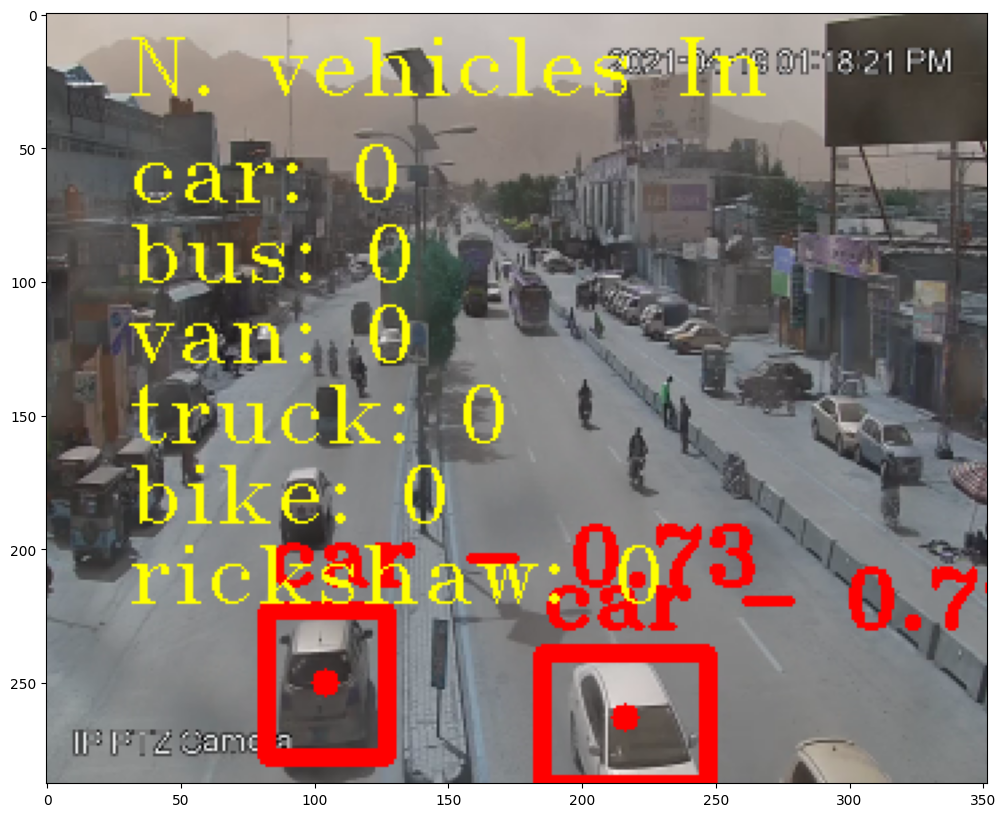

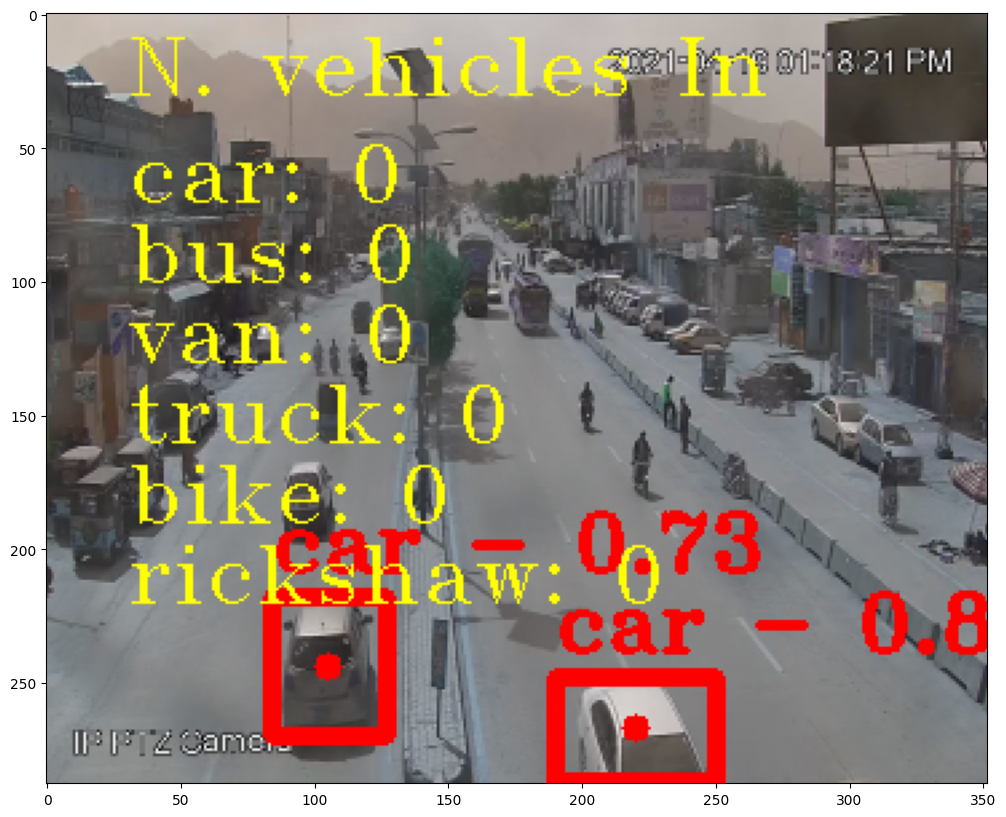

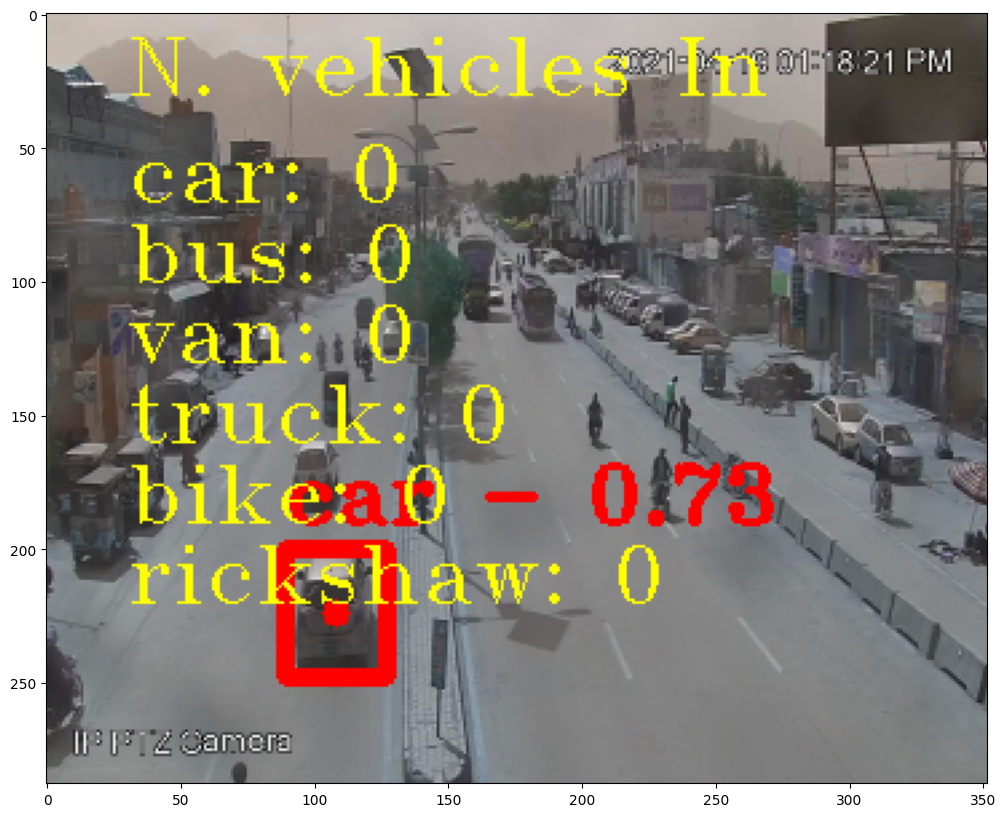

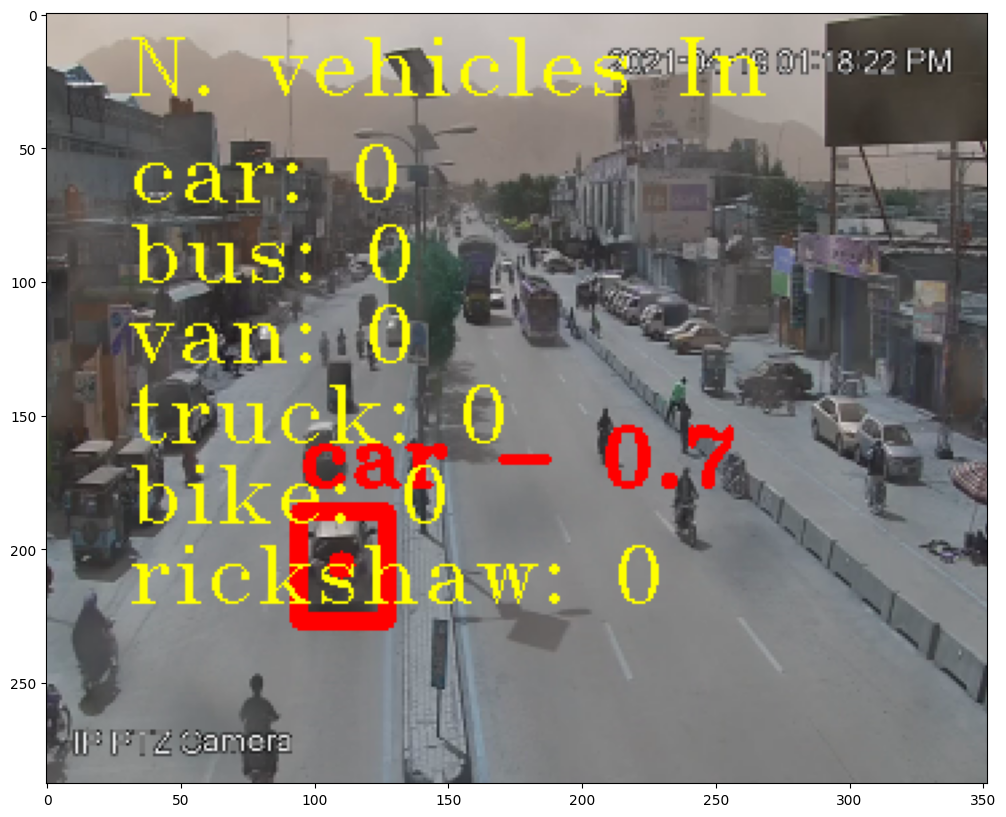

In [16]:
# Checking samples of processed frames
for i in [28, 29, 32, 40, 42, 50, 58]:
    plt.figure(figsize =( 14, 10))
    plt.imshow(frames_list[i])
    plt.show()

# Executing Result Video 

In [22]:
#output video result

cap = cv2.VideoCapture('tmp_rep_result.mp4')
print(cap.isOpened())
for i in   frames_list:
    # ret, frame = cap.read()
    # if ret == True:
    cv2.imshow('frame',i)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    else:
        break

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x26cd60c0] moov atom not found


False
